In [321]:
import altair as alt
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import shapely.geometry
from shapely.geometry import shape,Point,MultiPolygon
from shapely.geometry.polygon import Polygon
from shapely.ops import cascaded_union
import json
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
from random import randint

In [135]:
parquet_file = pq.ParquetFile('../data/raw/parquet/2019-04/sds011/part-00000-18b6bc00-8426-4900-851e-b650c25b6cee-c000.snappy.parquet')

In [110]:
chunks = []
for i in range(parquet_file.num_row_groups):
    current_data = parquet_file.read_row_group(i).to_pandas()
    chunks.append([current_data.loc[:,['sensor_id','lon','lat']]])

In [111]:
sensor_summ=[]
sensor_deff=[]
sensor_list=[]
for i in chunks:
    t=np.asarray(i[0])
    t_u=np.unique(t,axis=0)
    sensor_summ.append(t_u)
    
for s in sensor_summ:
    s_t=np.asarray(s)
    s_u=np.unique(s_t,axis=0)
    sensor_deff.extend([s_u])
    unique_sensor_list=np.asarray(sensor_deff)

for x in unique_sensor_list:
    for i in x:
        sensor_list.extend([i])
d_l=np.asarray(sensor_list)
d_l=np.unique(sensor_list,axis=0)

In [134]:
valid_sensors=d_l[np.where(np.isnan(d_l[:,0])==True,False,True)]

In [114]:
valid_sensors.shape

(9361, 3)

In [115]:
lat_lon=valid_sensors[:,1:3]

In [136]:
with open("../data/berlinbezirkt.geojson", "r") as read_file:
    bezirkt_grenzen = json.load(read_file)

In [97]:
bezirkt_geo=bezirkt_grenzen["features"]

In [100]:
bezirkt_shapes=[]
for bezirkt in bezirkt_geo:
    bezirkt_shapes.append([bezirkt["properties"]["Gemeinde_name"],shape(bezirkt["geometry"])])

In [222]:
berlin_sensors=[]
for point in valid_sensors:
    p=point[1:3]
    p=Point(p)
    for bezirkt in bezirkt_shapes:
        if bezirkt[1].contains(p):
            berlin_sensors.append([point[0],bezirkt[0],p])

In [258]:
points=[]
for i in berlin_sensors:
    points.extend([i[2]])

In [240]:
berlin_polygons=[]
for polygon in bezirkt_shapes:
    berlin_polygons.extend([polygon[1]])

In [241]:
berlin_geo = cascaded_union(berlin_polygons)

In [341]:
sensor_x=[]
sensor_y=[]
for sensor in points:
    sensor_x.append(sensor.x)
    sensor_y.append(sensor.y)

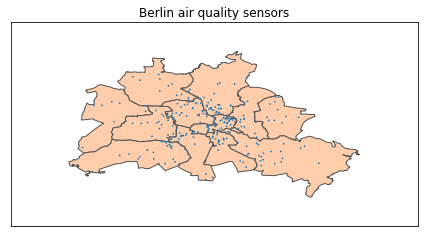

In [349]:
cm = plt.get_cmap('Pastel2')
num_colours = len(berlin_geo)
 
fig = plt.figure()
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = berlin_geo.bounds
w, h = maxx - minx, maxy - miny
ax.set_xlim(minx - 0.2 * w, maxx + 0.2 * w)
ax.set_ylim(miny - 0.2 * h, maxy + 0.2 * h)
ax.set_aspect(1)

patches = []
for idx, p in enumerate(berlin_polygons):
    colour = cm(1)
    patches.append(PolygonPatch(p, fc=colour, ec='#555555', alpha=1., zorder=1))

for sensor in points:
    p = Circle((sensor.x, sensor.y), 0.002)
    ax.add_patch(p)
    
ax.add_collection(PatchCollection(patches, match_original=True))
ax.set_xticks([])
ax.set_yticks([])
plt.title("Berlin air quality sensors")
plt.tight_layout()
plt.show()